### Frequency Domain Analysis

**Most signals are best understood in the frequency domain**

The primary objective is to analyze the spectral characteristics of real and fake audio samples.

Frequency domain analysis is crucial in audio processing as it provides insights into the distribution of energy across different frequency components of the audio signal.

### Purpose of this Notebook

1. **Load the Audio Data**

2. **Preprocess the Audio Data**
    - Normalize the audio signals to ensure uniform amplitude levels.

3. **Apply Windowing**
    - Use window functions (e.g., Hamming, Hanning) to reduce spectral leakage.

4. **Compute Short-Time Fourier Transform (STFT)**
    - Convert the audio signal from the time domain to the frequency domain using STFT.

5. **Compute Magnitude and Phase**
    - Extract the magnitude and phase of the frequency components from the STFT.

6. **Visualize the Spectrogram**
    - Create a spectrogram to visualize the frequency content over time.

7. **Analyze Frequency Components**
    - Examine the frequency components to identify patterns or anomalies in the audio data.

8. **Extract Features**
    - Derive relevant features from the frequency domain representation for further analysis.

9. **Compare Across Different Audio Files**
    - Compare the frequency domain characteristics of real and fake audio samples (real, f01, f02, etc.).

10. **Perform Statistical Analysis**
    - Conduct statistical analysis on the extracted features to quantify differences between real and fake audio.

11. **Train Machine Learning Model**
    - Utilize the extracted features to train a machine learning model for audio deepfake detection.

12. **Evaluate Model Performance**
    - Assess the performance of the model using metrics such as accuracy, precision, recall, and F1-score.

The purpose of this notebook is to:
- Compute and visualize the spectrograms of real and fake audio samples.
- Analyze the energy distribution across different frequency ranges.
- Identify and compare the significant frequency components in real and fake audio.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display as ld

from tqdm import tqdm

### Load the Audio Data

In [4]:
from data.load.data_loader import get_codecfake_audio_id_list, load_audio_data

# Loading Data
def get_audio_ids(ids=None, indices=None, first_n=None, last_n=None, random_n=None, seed=None):
    all_audio_ids = get_codecfake_audio_id_list()
    
    if ids is not None:
        return ids
    elif indices is not None:
        return [all_audio_ids[i] for i in indices]
    elif first_n is not None:
        return all_audio_ids[:first_n]
    elif last_n is not None:
        return all_audio_ids[-last_n:]
    elif random_n is not None:
        if seed is not None:
            random.seed(seed)
        return random.sample(all_audio_ids, random_n)
    else:
        return all_audio_ids

def get_iterable_dataset(ids=None, indices=None, first_n=None, last_n=None, random_n=None, seed=None, cache_dir=None):
    audio_ids = get_audio_ids(ids=ids, indices=indices, first_n=first_n, last_n=last_n, random_n=random_n, seed=seed)
    iterable_dataset = load_audio_data(
        audio_ids=audio_ids,
        dataset='codecfake',
        cache_dir=cache_dir
    )
    return iterable_dataset

# Function to load and resample audio
def load_audio(audio_id, real_or_fake):
    sample = next(sample for sample in get_iterable_dataset(ids=[audio_id]) if sample['audio_id'] == audio_id and sample['real_or_fake'] == real_or_fake)
    audio_array = sample['audio']['array']
    sampling_rate = sample['audio']['sampling_rate']
    return audio_array, sampling_rate

def resample_audio(audio_array, orig_sr, target_sr=16000):
    if orig_sr != target_sr:
        audio_array = librosa.resample(audio_array, orig_sr=orig_sr, target_sr=target_sr)
    return audio_array, target_sr

In [5]:
# Load sample audio
all_audio_ids = get_codecfake_audio_id_list()
audio_id = all_audio_ids[55]
real_audio, real_sr = load_audio(audio_id, 'R')
fake_audio, fake_sr = load_audio(audio_id, 'F03')

### Preprocess the Audio Data

In [6]:
real_audio = librosa.util.normalize(real_audio)
fake_audio = librosa.util.normalize(fake_audio)

### Apply Windowing

In [8]:
window = np.hanning(len(real_audio))
real_audio_windowed = real_audio * window
window = np.hanning(len(fake_audio))
fake_audio_windowed = fake_audio * window

### Compute Short-Time Fourier Transform (STFT)

In [9]:
real_stft = librosa.stft(real_audio_windowed, n_fft=2048, hop_length=512, window='hann')
fake_stft = librosa.stft(fake_audio_windowed, n_fft=2048, hop_length=512, window='hann')

### Compute Magnitude and Phase

In [10]:
real_magnitude = np.abs(real_stft)
real_phase = np.angle(real_stft)

fake_magnitude = np.abs(fake_stft)
fake_phase = np.angle(fake_stft)

### Visualize the Spectrogram

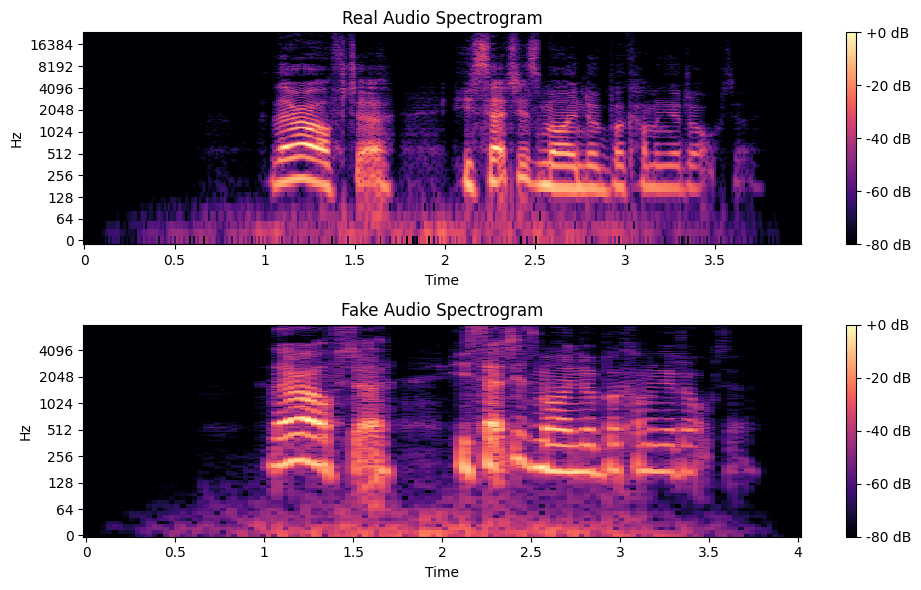

In [11]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(real_magnitude, ref=np.max), sr=real_sr, hop_length=512, x_axis='time', y_axis='log')
plt.title('Real Audio Spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(fake_magnitude, ref=np.max), sr=fake_sr, hop_length=512, x_axis='time', y_axis='log')
plt.title('Fake Audio Spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

### Analyze Frequency Components

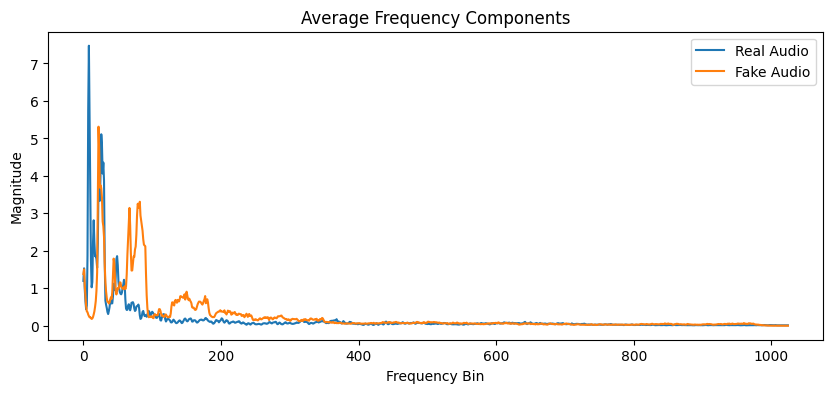

In [12]:
# Extracting specific frequency components or bands for further analysis
real_freq_components = real_magnitude.mean(axis=1)
fake_freq_components = fake_magnitude.mean(axis=1)

plt.figure(figsize=(10, 4))
plt.plot(real_freq_components, label='Real Audio')
plt.plot(fake_freq_components, label='Fake Audio')
plt.xlabel('Frequency Bin')
plt.ylabel('Magnitude')
plt.title('Average Frequency Components')
plt.legend()
plt.show()

### Analyze Phase Components

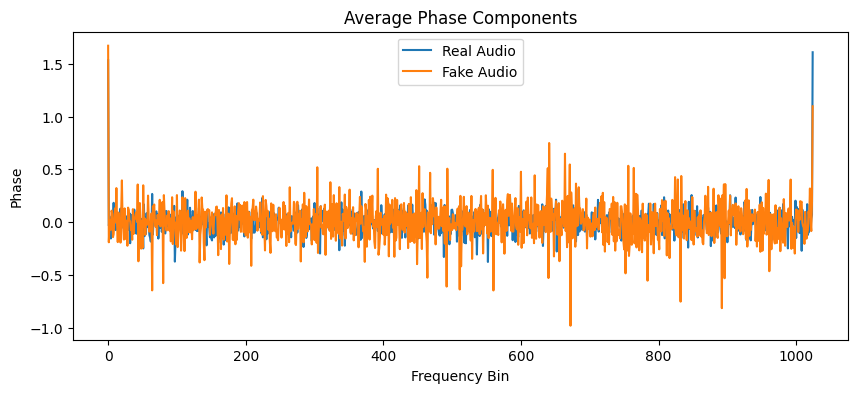

In [18]:
# Extracting phase components for analysis
real_phase_components = real_phase.mean(axis=1)
fake_phase_components = fake_phase.mean(axis=1)

plt.figure(figsize=(10, 4))
plt.plot(real_phase_components, label='Real Audio')
plt.plot(fake_phase_components, label='Fake Audio')
plt.xlabel('Frequency Bin')
plt.ylabel('Phase')
plt.title('Average Phase Components')
plt.legend()
plt.show()


### Extract Features: Mean and variance of the magnitude and phase spectrum

In [19]:
def extract_features(magnitude, phase):
    # Example features: Mean and variance of the magnitude and phase spectrum
    mean_magnitude = np.mean(magnitude, axis=1)
    var_magnitude = np.var(magnitude, axis=1)
    mean_phase = np.mean(phase, axis=1)
    var_phase = np.var(phase, axis=1)
    return mean_magnitude, var_magnitude, mean_phase, var_phase

real_mean_mag, real_var_mag, real_mean_phase, real_var_phase = extract_features(real_magnitude, real_phase)
fake_mean_mag, fake_var_mag, fake_mean_phase, fake_var_phase = extract_features(fake_magnitude, fake_phase)


In [20]:
from scipy.stats import ttest_ind

t_stat_mag, p_value_mag = ttest_ind(real_mean_mag, fake_mean_mag)
t_stat_phase, p_value_phase = ttest_ind(real_mean_phase, fake_mean_phase)
print(f'T-test statistics for magnitude: {t_stat_mag}, p-value: {p_value_mag}')
print(f'T-test statistics for phase: {t_stat_phase}, p-value: {p_value_phase}')

T-test statistics for magnitude: -3.018959447384057, p-value: 0.0025677532397581438
T-test statistics for phase: -0.9595836841804429, p-value: 0.33737805372175267


### Frequency Domain

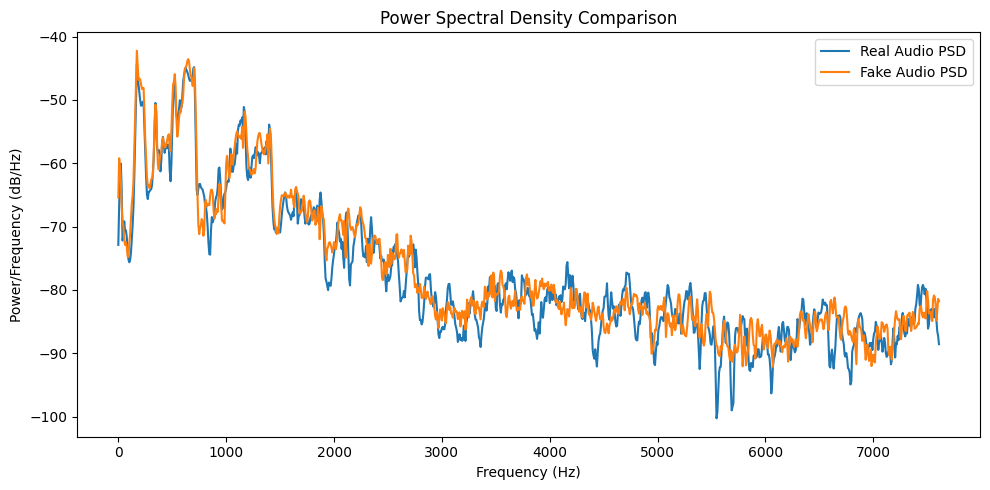

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, detrend

def plot_psd(audio_array, sampling_rate, detrend_signal=False):
    if detrend_signal:
        audio_array = detrend(audio_array)
    freqs, psd = welch(audio_array, fs=sampling_rate, nperseg=2048, noverlap=1024)
    return freqs[:-50], 10 * np.log10(psd[:-50])
all_audio_ids = get_codecfake_audio_id_list()
audio_id = all_audio_ids[55]
real_audio, real_sr = load_audio(audio_id, 'R')
fake_audio, fake_sr = load_audio(audio_id, 'F03') 
real_audio, real_sr = resample_audio(real_audio, real_sr, target_sr=16000)
fake_audio, fake_sr = resample_audio(fake_audio, fake_sr, target_sr=16000)

# Calculate PSDs
real_freqs, real_psd = plot_psd(real_audio, real_sr)
fake_freqs, fake_psd = plot_psd(fake_audio, fake_sr)

# Plot PSDs on the same graph
plt.figure(figsize=(10, 5))
plt.plot(real_freqs, real_psd, label='Real Audio PSD')
plt.plot(fake_freqs, fake_psd, label='Fake Audio PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Power Spectral Density Comparison')
plt.legend()
plt.tight_layout()
plt.show()


Frequency Range 0-1000 Hz: t-statistic = -0.0163, p-value = 0.9870
Frequency Range 1000-5000 Hz: t-statistic = 2.5794, p-value = 0.0100
Frequency Range 5000-8000 Hz: t-statistic = 5.9839, p-value = 0.0000


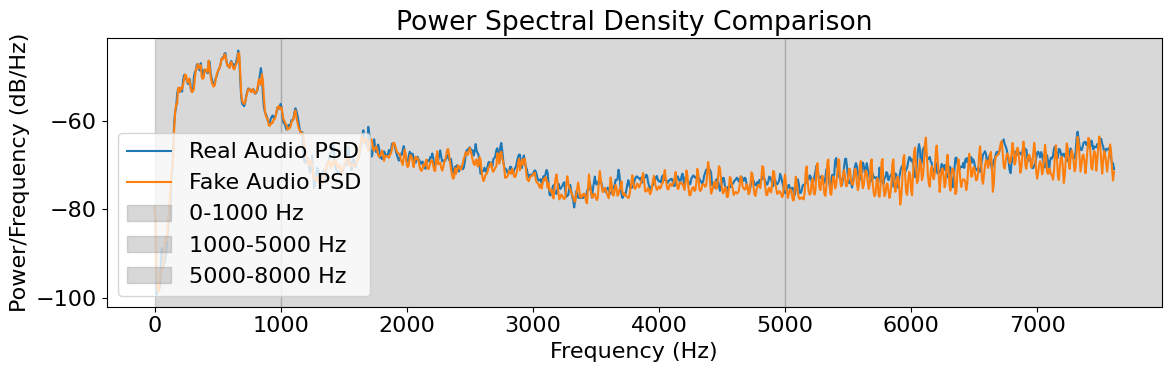

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, detrend
from scipy.stats import ttest_ind

def compute_psd(audio_array, sampling_rate, detrend_signal=False):
    if detrend_signal:
        audio_array = detrend(audio_array)
    freqs, psd = welch(audio_array, fs=sampling_rate, nperseg=2048, noverlap=1024)
    return freqs[:-50], 10 * np.log10(psd[:-50])

def segment_psd(freqs, psd, ranges):
    segmented_psd = {}
    for r in ranges:
        mask = (freqs >= r[0]) & (freqs < r[1])
        segmented_psd[r] = psd[mask]
    return segmented_psd

def compute_statistics(segmented_psd):
    stats = {}
    for r, psd_values in segmented_psd.values():
        stats[r] = {
            'mean': np.mean(psd_values),
            'variance': np.var(psd_values)
        }
    return stats

def perform_t_tests(segmented_psd_real, segmented_psd_fake):
    t_test_results = {}
    for r in segmented_psd_real.keys():
        t_stat, p_value = ttest_ind(segmented_psd_real[r], segmented_psd_fake[r])
        t_test_results[r] = {'t_stat': t_stat, 'p_value': p_value}
    return t_test_results

# audio_id = all_audio_ids[1023]
# real_audio, real_sr = load_audio(audio_id, 'R')
# fake_audio, fake_sr = load_audio(audio_id, 'F02')
real_audio, real_sr = sf.read('/app/data/temp/real.wav')
fake_audio, fake_sr = sf.read('/app/data/temp/fake.wav')

real_audio, real_sr = resample_audio(real_audio, real_sr, target_sr=16000)
fake_audio, fake_sr = resample_audio(fake_audio, fake_sr, target_sr=16000)

# Compute PSDs
real_freqs, real_psd = compute_psd(real_audio, real_sr, detrend_signal=False)
fake_freqs, fake_psd = compute_psd(fake_audio, fake_sr, detrend_signal=False)

# Segment PSD values into frequency ranges
ranges = [(0, 1000), (1000, 5000), (5000, 8000)]
segmented_psd_real = segment_psd(real_freqs, real_psd, ranges)
segmented_psd_fake = segment_psd(fake_freqs, fake_psd, ranges)

# Perform statistical tests
t_test_results = perform_t_tests(segmented_psd_real, segmented_psd_fake)

# Display the results
for r, result in t_test_results.items():
    print(f"Frequency Range {r[0]}-{r[1]} Hz: t-statistic = {result['t_stat']:.4f}, p-value = {result['p_value']:.4f}")

# Plotting the results for visualization
def plot_psd_comparison(real_psd, fake_psd, freqs, ranges):
    plt.figure(figsize=(12, 4))
    plt.plot(freqs, real_psd, label='Real Audio PSD')
    plt.plot(freqs, fake_psd, label='Fake Audio PSD')
    
    for r in ranges:
        plt.axvspan(r[0], r[1], color='gray', alpha=0.3, label=f'{r[0]}-{r[1]} Hz')
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.title('Power Spectral Density Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_psd_comparison(real_psd, fake_psd, real_freqs, ranges)


Frequency Range 0-1000 Hz: t-statistic = -0.0163, p-value = 0.9870
Frequency Range 1000-5000 Hz: t-statistic = 2.5794, p-value = 0.0100
Frequency Range 5000-8000 Hz: t-statistic = 5.9839, p-value = 0.0000


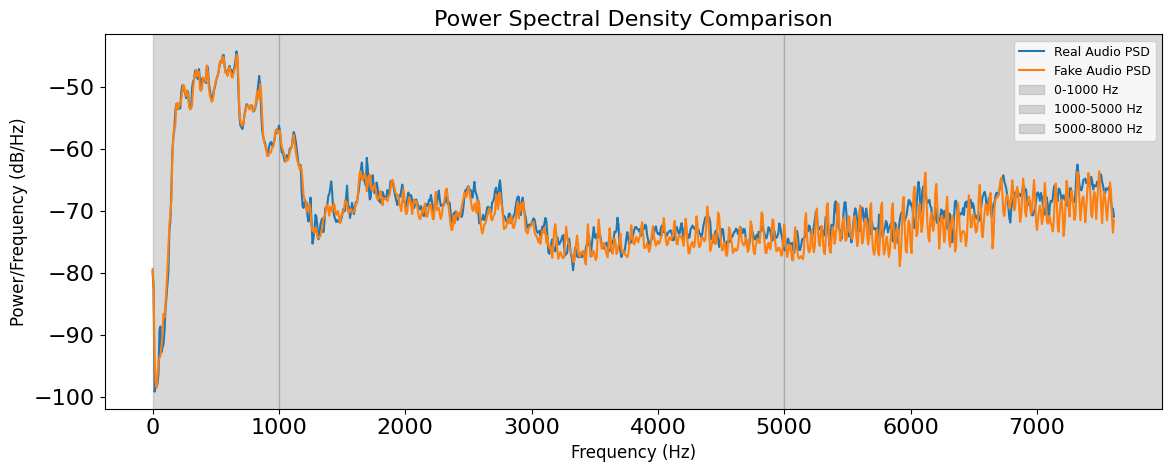

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, detrend
from scipy.stats import ttest_ind
import soundfile as sf
import librosa

# Increase font size
# plt.rcParams.update({'font.size': 16})

def resample_audio(audio, orig_sr, target_sr=16000):
    return librosa.resample(audio, orig_sr=orig_sr, target_sr=target_sr), target_sr

def compute_psd(audio_array, sampling_rate, detrend_signal=False):
    if detrend_signal:
        audio_array = detrend(audio_array)
    freqs, psd = welch(audio_array, fs=sampling_rate, nperseg=2048, noverlap=1024)
    return freqs[:-50], 10 * np.log10(psd[:-50])

def segment_psd(freqs, psd, ranges):
    segmented_psd = {}
    for r in ranges:
        mask = (freqs >= r[0]) & (freqs < r[1])
        segmented_psd[r] = psd[mask]
    return segmented_psd

def compute_statistics(segmented_psd):
    stats = {}
    for r, psd_values in segmented_psd.values():
        stats[r] = {
            'mean': np.mean(psd_values),
            'variance': np.var(psd_values)
        }
    return stats

def perform_t_tests(segmented_psd_real, segmented_psd_fake):
    t_test_results = {}
    for r in segmented_psd_real.keys():
        t_stat, p_value = ttest_ind(segmented_psd_real[r], segmented_psd_fake[r])
        t_test_results[r] = {'t_stat': t_stat, 'p_value': p_value}
    return t_test_results

# Load and resample audio files
real_audio, real_sr = sf.read('/app/data/temp/real.wav')
fake_audio, fake_sr = sf.read('/app/data/temp/fake.wav')
real_audio, real_sr = resample_audio(real_audio, real_sr, target_sr=16000)
fake_audio, fake_sr = resample_audio(fake_audio, fake_sr, target_sr=16000)

# Compute PSDs
real_freqs, real_psd = compute_psd(real_audio, real_sr, detrend_signal=False)
fake_freqs, fake_psd = compute_psd(fake_audio, fake_sr, detrend_signal=False)

# Segment PSD values into frequency ranges
ranges = [(0, 1000), (1000, 5000), (5000, 8000)]
segmented_psd_real = segment_psd(real_freqs, real_psd, ranges)
segmented_psd_fake = segment_psd(fake_freqs, fake_psd, ranges)

# Perform statistical tests
t_test_results = perform_t_tests(segmented_psd_real, segmented_psd_fake)

# Display the results
for r, result in t_test_results.items():
    print(f"Frequency Range {r[0]}-{r[1]} Hz: t-statistic = {result['t_stat']:.4f}, p-value = {result['p_value']:.4f}")

def plot_psd_comparison(real_psd, fake_psd, freqs, ranges):
    plt.figure(figsize=(12, 5))
    plt.plot(freqs, real_psd, label='Real Audio PSD')
    plt.plot(freqs, fake_psd, label='Fake Audio PSD')
    
    for r in ranges:
        plt.axvspan(r[0], r[1], color='gray', alpha=0.3, label=f'{r[0]}-{r[1]} Hz')
    
    plt.xlabel('Frequency (Hz)', fontsize=12)
    plt.ylabel('Power/Frequency (dB/Hz)', fontsize=12)
    plt.title('Power Spectral Density Comparison', fontsize=16)
    plt.legend(fontsize=9)
    
    plt.tight_layout()
    plt.show()

plot_psd_comparison(real_psd, fake_psd, real_freqs, ranges)


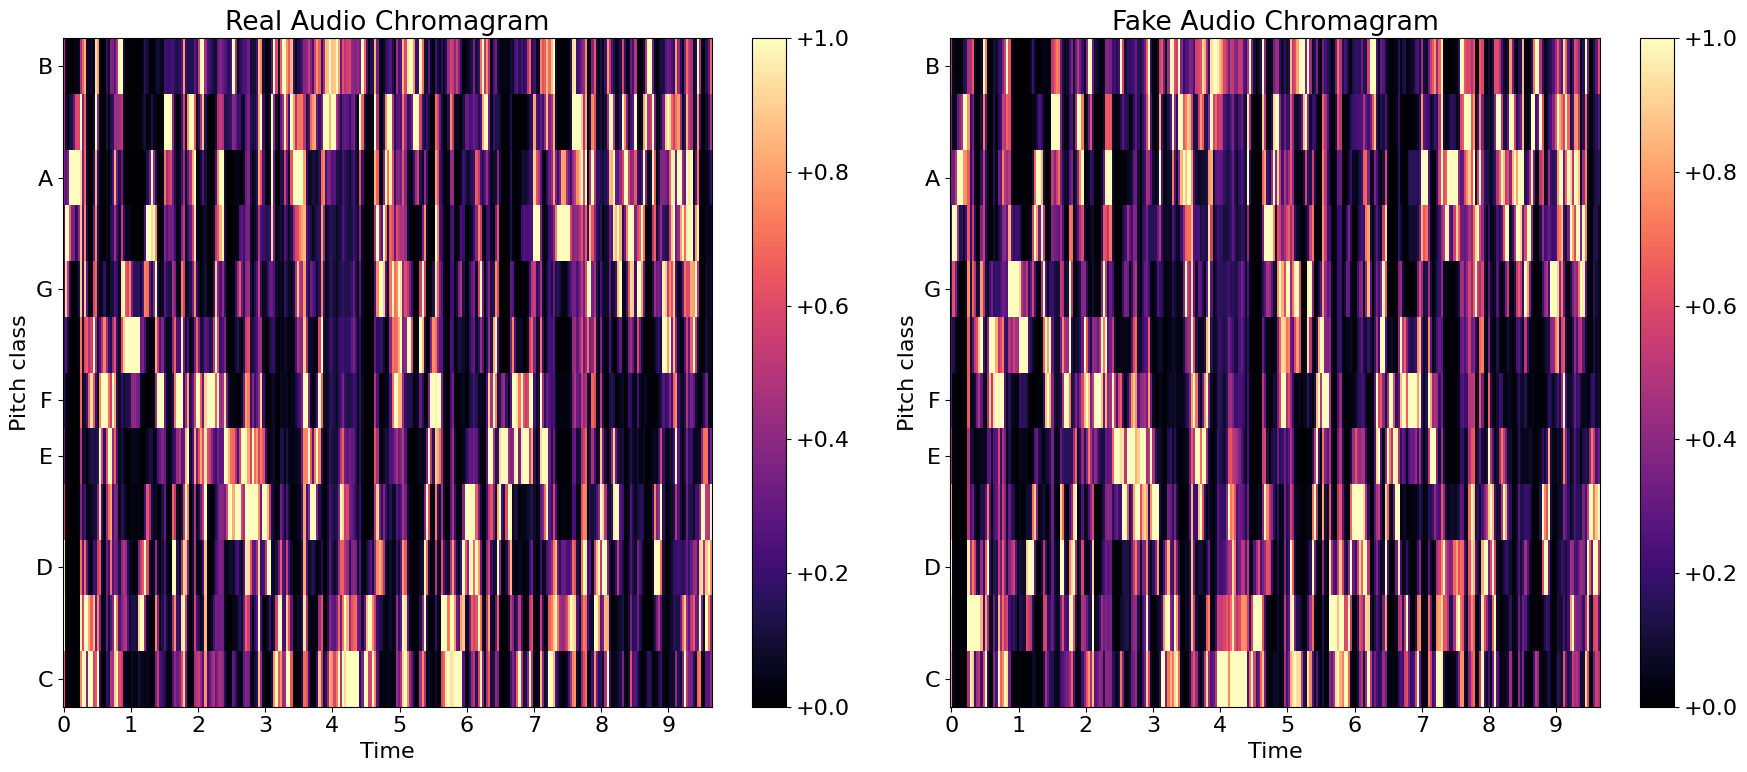

In [192]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display as ld
import soundfile as sf

def plot_chromagram_side_by_side(real_audio, real_sr, fake_audio, fake_sr):
    real_chroma = librosa.feature.chroma_stft(y=real_audio, sr=real_sr)
    fake_chroma = librosa.feature.chroma_stft(y=fake_audio, sr=fake_sr)
    
    plt.figure(figsize=(18, 8))
    
    # Plot real audio chromagram
    plt.subplot(1, 2, 1)
    ld.specshow(real_chroma, y_axis='chroma', x_axis='time', sr=real_sr, cmap='magma', vmin=0, vmax=1)
    plt.colorbar(format='%+0.1f')
    plt.title('Real Audio Chromagram')
    
    # Plot fake audio chromagram
    plt.subplot(1, 2, 2)
    ld.specshow(fake_chroma, y_axis='chroma', x_axis='time', sr=fake_sr, cmap='magma', vmin=0, vmax=1)
    plt.colorbar(format='%+0.1f')
    plt.title('Fake Audio Chromagram')
    
    plt.tight_layout()
    plt.show()

# Load and process your audio samples
real_audio, real_sr = sf.read('/app/data/temp/real.wav')
fake_audio, fake_sr = sf.read('/app/data/temp/fake.wav')

real_audio, real_sr = resample_audio(real_audio, real_sr, target_sr=16000)
fake_audio, fake_sr = resample_audio(fake_audio, fake_sr, target_sr=16000)

# Plot chromagrams side-by-side
plot_chromagram_side_by_side(real_audio, real_sr, fake_audio, fake_sr)


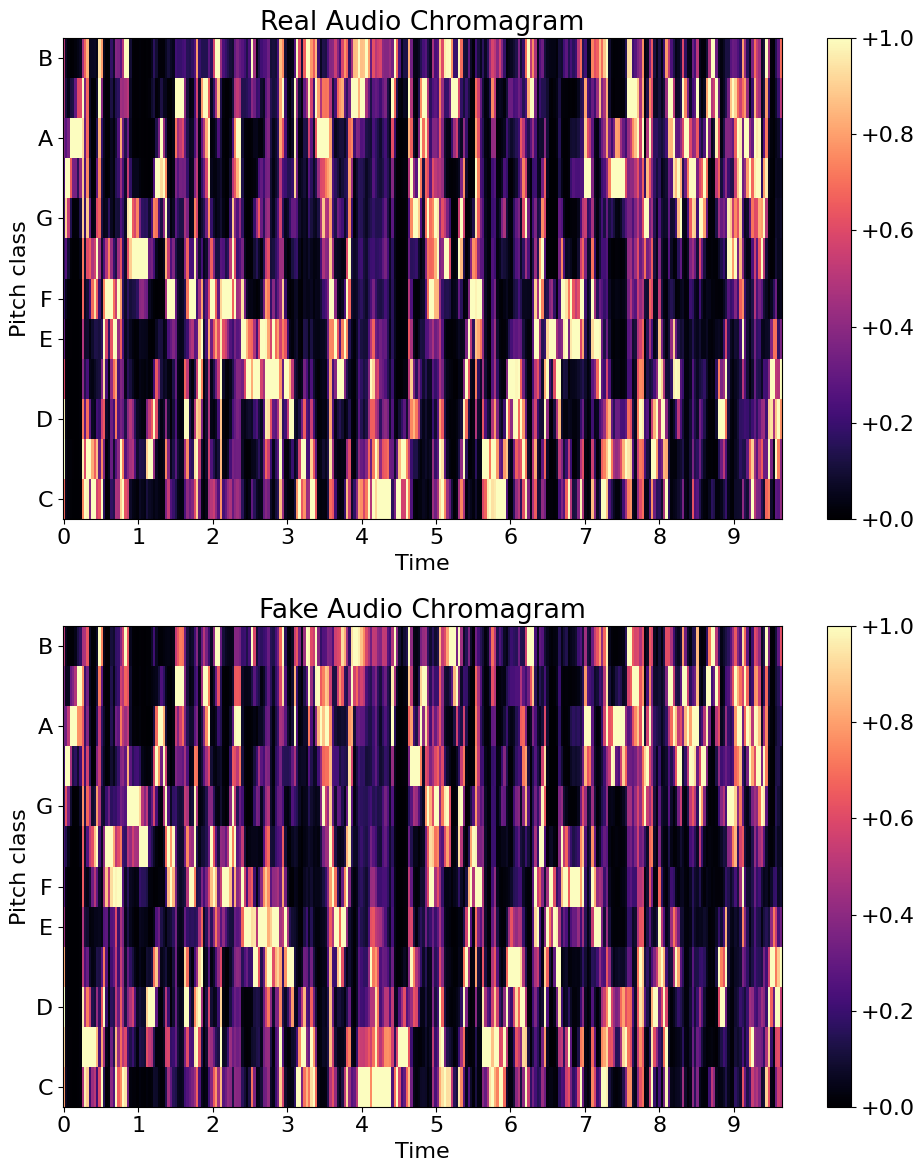

Real Audio Chroma Mean: [0.34784102 0.35182731 0.30649705 0.31430118 0.31029405 0.30502399
 0.27832794 0.29972549 0.32452952 0.3258085  0.35171103 0.32416632]
Real Audio Chroma Variance: [0.11346522 0.11130145 0.09414885 0.11104389 0.10306551 0.11032799
 0.0844127  0.08806976 0.10593839 0.10583395 0.11541316 0.09259574]
Fake Audio Chroma Mean: [0.35539076 0.35270866 0.32303617 0.31199323 0.28012713 0.3061452
 0.28361762 0.29230311 0.30920614 0.34530128 0.3223276  0.32949917]
Fake Audio Chroma Variance: [0.11267787 0.11179199 0.09750498 0.10507855 0.08834812 0.10860696
 0.09101331 0.08686588 0.09047186 0.11602013 0.10447123 0.09568861]


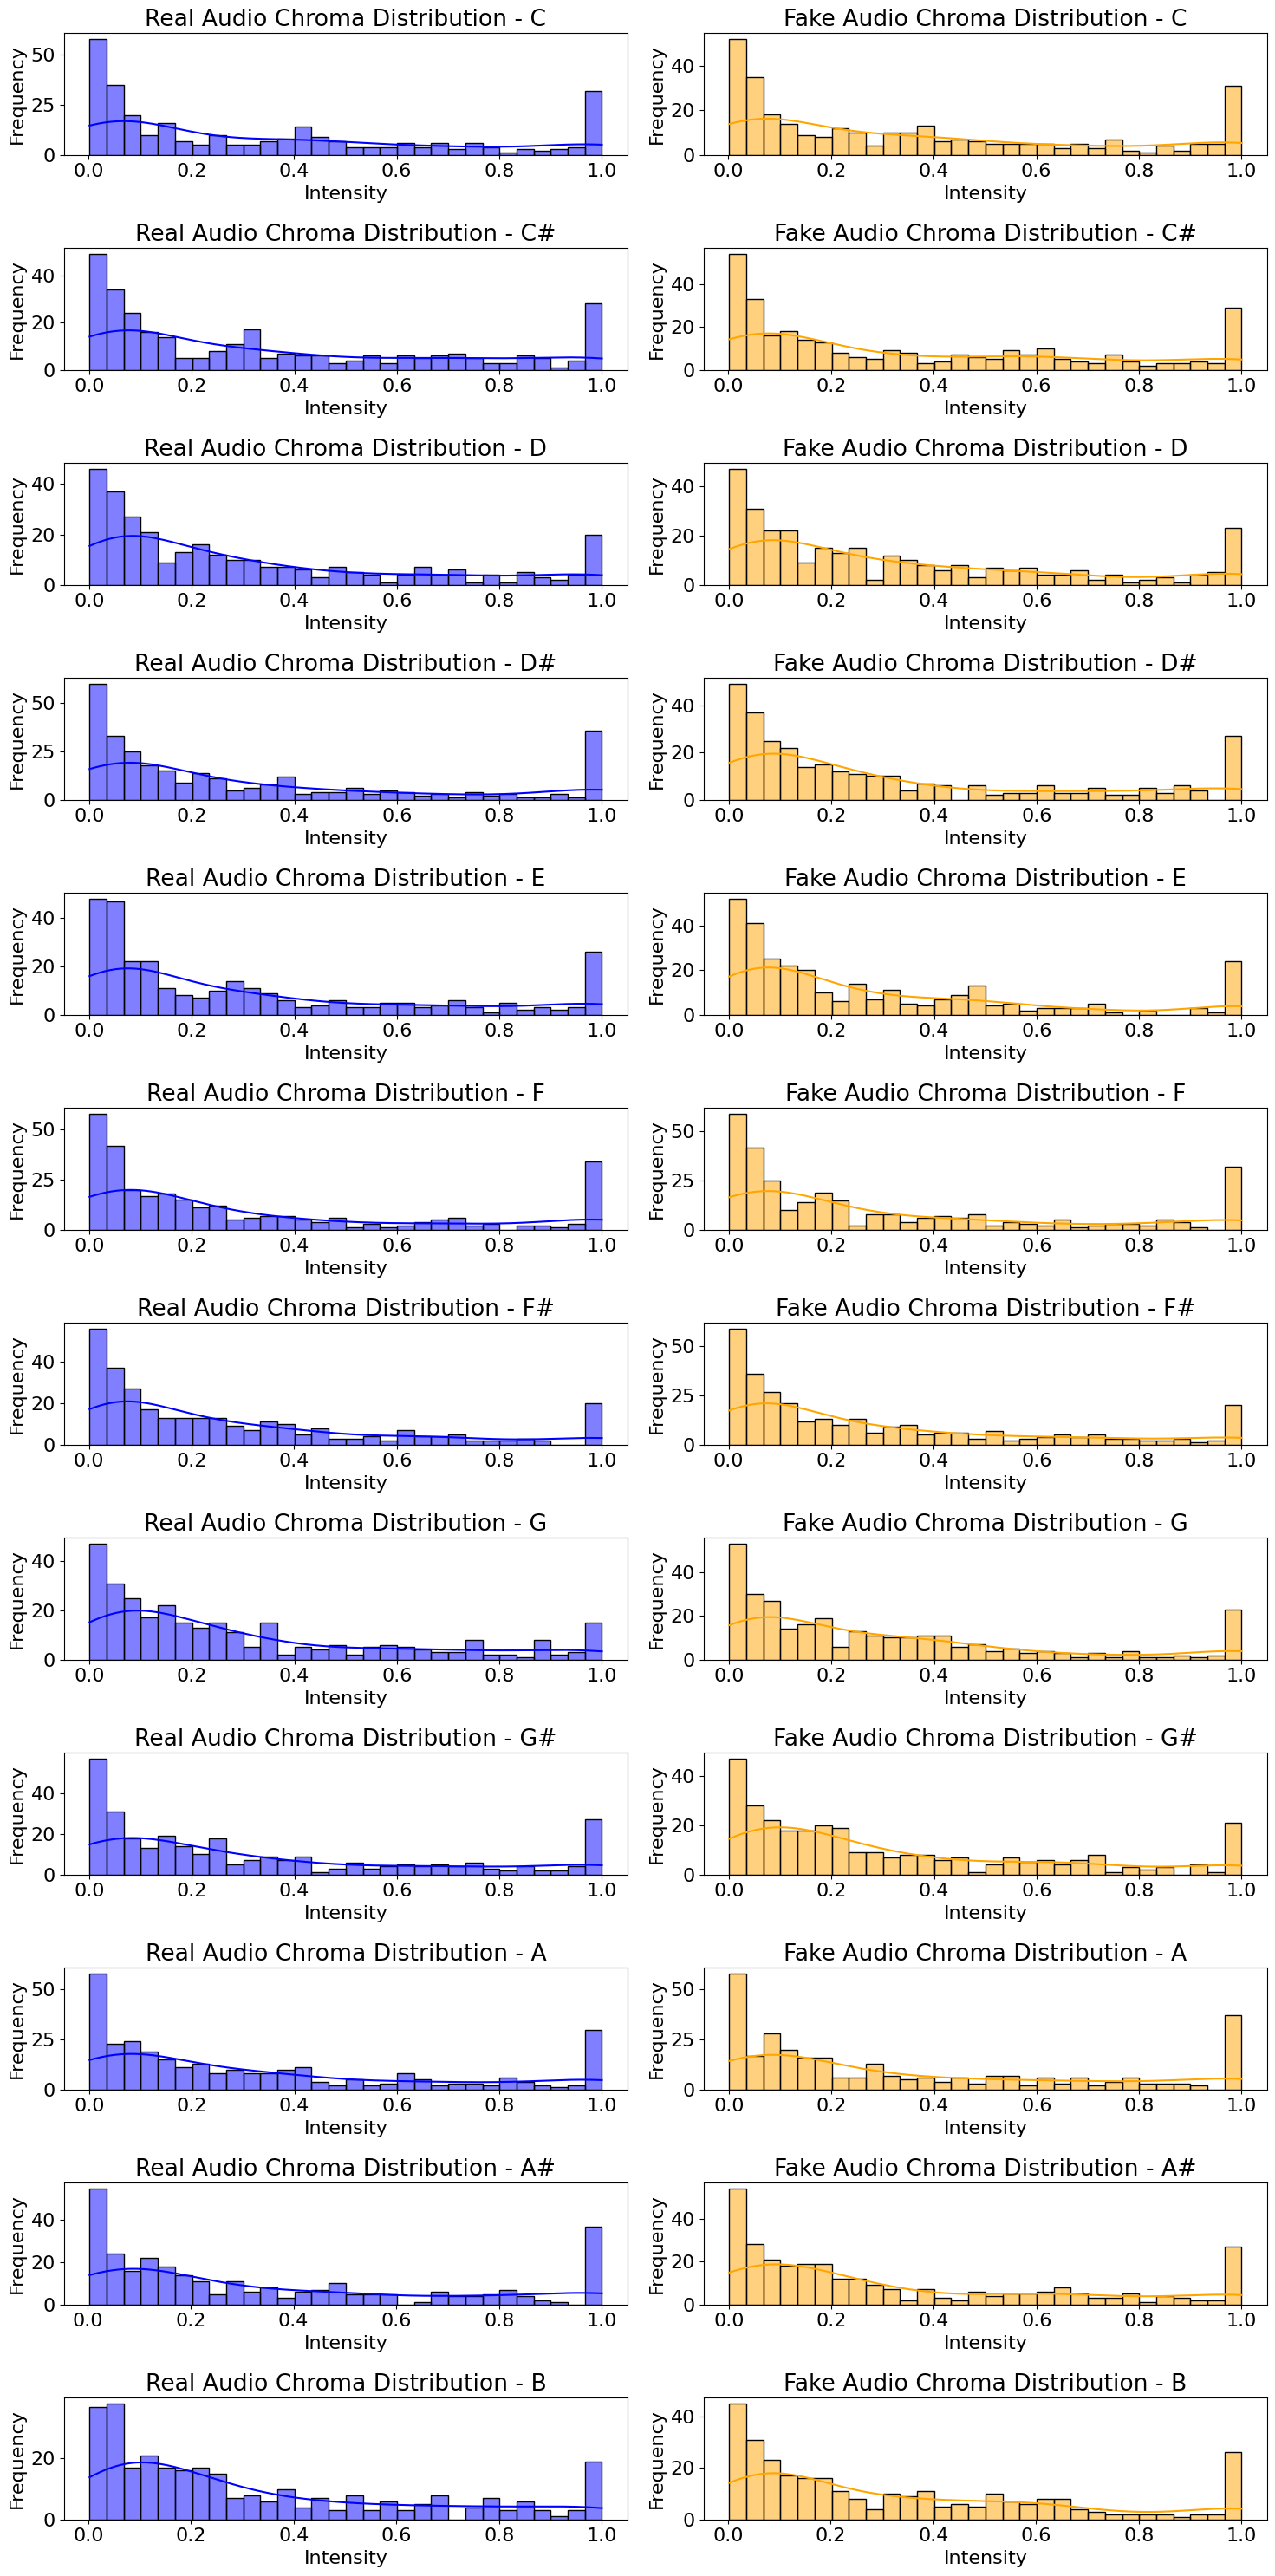

Pitch Class C: t-statistic = -0.2754, p-value = 0.7831
Pitch Class C#: t-statistic = -0.0324, p-value = 0.9742
Pitch Class D: t-statistic = -0.6554, p-value = 0.5124
Pitch Class D#: t-statistic = 0.0861, p-value = 0.9314
Pitch Class E: t-statistic = 1.1963, p-value = 0.2321
Pitch Class F: t-statistic = -0.0416, p-value = 0.9669
Pitch Class F#: t-statistic = -0.2191, p-value = 0.8266
Pitch Class G: t-statistic = 0.3079, p-value = 0.7583
Pitch Class G#: t-statistic = 0.5999, p-value = 0.5488
Pitch Class A: t-statistic = -0.7180, p-value = 0.4730
Pitch Class A#: t-statistic = 1.0871, p-value = 0.2774
Pitch Class B: t-statistic = -0.2132, p-value = 0.8312


In [197]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import soundfile as sf

def resample_audio(audio, orig_sr, target_sr=16000):
    return librosa.resample(audio, orig_sr=orig_sr, target_sr=target_sr), target_sr

def plot_chromagram_row_by_row(real_audio, real_sr, fake_audio, fake_sr):
    real_chroma = librosa.feature.chroma_stft(y=real_audio, sr=real_sr)
    fake_chroma = librosa.feature.chroma_stft(y=fake_audio, sr=fake_sr)
    
    plt.figure(figsize=(10, 12))
    
    plt.subplot(2, 1, 1)
    librosa.display.specshow(real_chroma, y_axis='chroma', x_axis='time', sr=real_sr, cmap='magma', vmin=0, vmax=1)
    plt.colorbar(format='%+0.1f')
    plt.title('Real Audio Chromagram')
    
    plt.subplot(2, 1, 2)
    librosa.display.specshow(fake_chroma, y_axis='chroma', x_axis='time', sr=fake_sr, cmap='magma', vmin=0, vmax=1)
    plt.colorbar(format='%+0.1f')
    plt.title('Fake Audio Chromagram')
    
    plt.tight_layout()
    plt.show()
    
    return real_chroma, fake_chroma

def calculate_chroma_stats(chroma):
    mean_chroma = np.mean(chroma, axis=1)
    var_chroma = np.var(chroma, axis=1)
    return mean_chroma, var_chroma

def plot_chroma_distribution_per_class(real_chroma, fake_chroma, labels):
    fig, axs = plt.subplots(len(labels), 2, figsize=(15, 30))
    
    for i, label in enumerate(labels):
        sns.histplot(real_chroma[i, :], kde=True, color='blue', ax=axs[i, 0], bins=30)
        axs[i, 0].set_title(f'Real Audio Chroma Distribution - {label}')
        axs[i, 0].set_xlabel('Intensity')
        axs[i, 0].set_ylabel('Frequency')
        
        sns.histplot(fake_chroma[i, :], kde=True, color='orange', ax=axs[i, 1], bins=30)
        axs[i, 1].set_title(f'Fake Audio Chroma Distribution - {label}')
        axs[i, 1].set_xlabel('Intensity')
        axs[i, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

def perform_t_tests(real_chroma, fake_chroma, labels):
    t_test_results = {}
    for i, label in enumerate(labels):
        t_stat, p_value = ttest_ind(real_chroma[i, :], fake_chroma[i, :])
        t_test_results[label] = {'t_stat': t_stat, 'p_value': p_value}
    return t_test_results

def display_t_test_results(t_test_results):
    for label, result in t_test_results.items():
        print(f"Pitch Class {label}: t-statistic = {result['t_stat']:.4f}, p-value = {result['p_value']:.4f}")

# Load and process your audio samples
real_audio, real_sr = sf.read('/app/data/temp/real.wav')
fake_audio, fake_sr = sf.read('/app/data/temp/fake.wav')

real_audio, real_sr = resample_audio(real_audio, real_sr, target_sr=16000)
fake_audio, fake_sr = resample_audio(fake_audio, fake_sr, target_sr=16000)

# Plot chromagrams row-by-row and get chroma features
real_chroma, fake_chroma = plot_chromagram_row_by_row(real_audio, real_sr, fake_audio, fake_sr)

# Calculate chroma statistics
real_mean_chroma, real_var_chroma = calculate_chroma_stats(real_chroma)
fake_mean_chroma, fake_var_chroma = calculate_chroma_stats(fake_chroma)

# Display the results
print("Real Audio Chroma Mean:", real_mean_chroma)
print("Real Audio Chroma Variance:", real_var_chroma)
print("Fake Audio Chroma Mean:", fake_mean_chroma)
print("Fake Audio Chroma Variance:", fake_var_chroma)

# Labels for pitch classes
labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

# Plot the distribution of chroma intensities per class
plot_chroma_distribution_per_class(real_chroma, fake_chroma, labels)

# Perform t-tests
t_test_results = perform_t_tests(real_chroma, fake_chroma, labels)

# Display t-test results
display_t_test_results(t_test_results)


In [154]:
from IPython.display import Audio
Audio(real_audio, rate=real_sr)

In [155]:
Audio(fake_audio, rate=fake_sr)

In [164]:
# Define the frequency range for the band-pass filter
lowcut = 60  # Low cut-off frequency in Hz
highcut = 70.0  # High cut-off frequency in Hz

# Apply the band-pass filter to the audio signal
filtered_audio = bandpass_filter(real_audio, real_sr, lowcut, highcut)

# Save the filtered audio to a file (optional)
sf.write('filtered_audio.wav', filtered_audio, real_sr)

# Play the filtered audio
Audio(filtered_audio, rate=real_sr)

In [165]:
# Define the frequency range for the band-pass filter
lowcut = 60  # Low cut-off frequency in Hz
highcut = 70.0  # High cut-off frequency in Hz

# Apply the band-pass filter to the audio signal
filtered_audio = bandpass_filter(fake_audio, fake_sr, lowcut, highcut)

# Save the filtered audio to a file (optional)
sf.write('filtered_audio.wav', filtered_audio, fake_sr)

# Play the filtered audio
Audio(filtered_audio, rate=fake_sr)

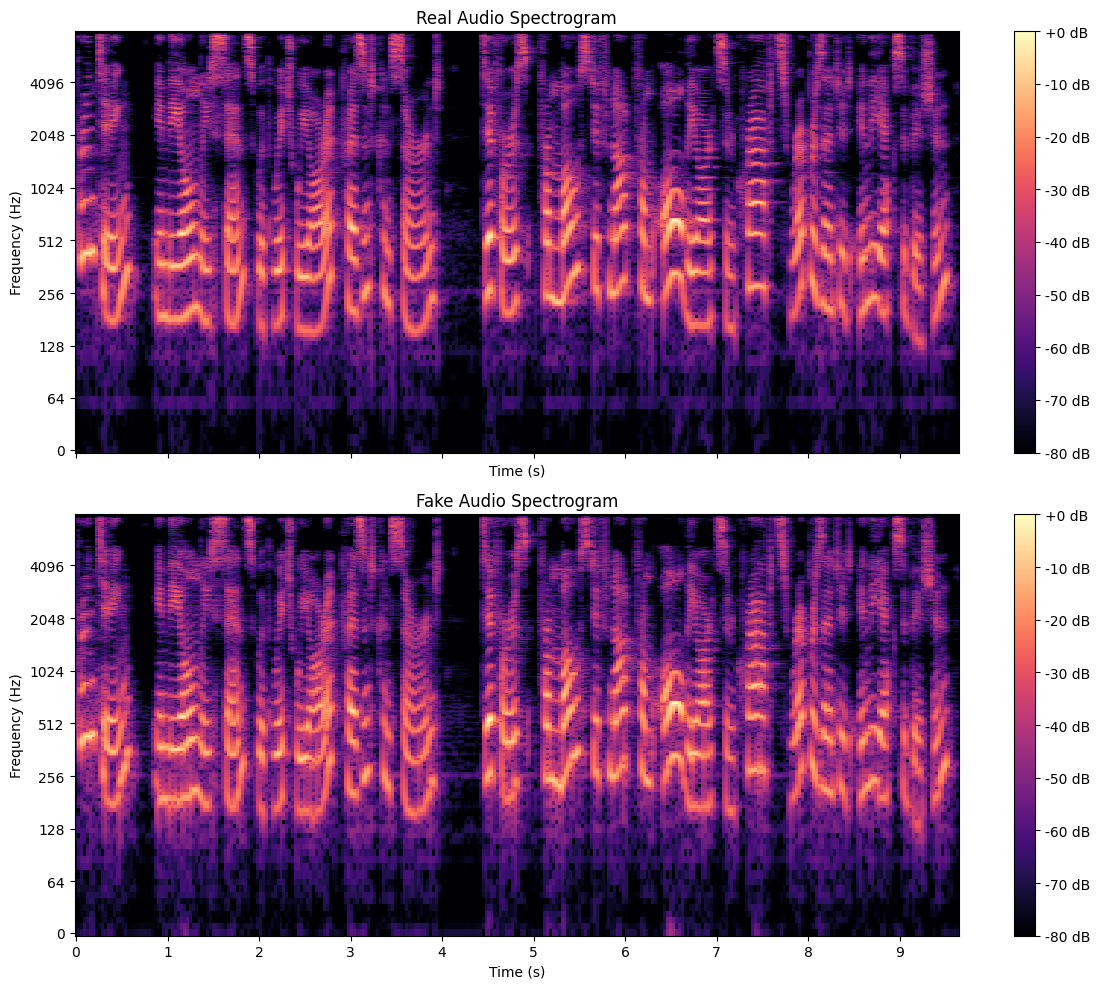

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display as ld
import soundfile as sf

def compute_spectrogram(audio_array, sr):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_array)), ref=np.max)
    return D

def plot_annotated_spectrogram(D, sr, ax, title='Spectrogram', vmin=None, vmax=None):
    img = ld.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=ax, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    
    # Add horizontal lines to mark frequency regions
    # ax.axhline(y=1000, color='white', linestyle='--', linewidth=1)
    # ax.axhline(y=5000, color='white', linestyle='--', linewidth=1)
    # ax.axhline(y=8000, color='white', linestyle='--', linewidth=1)
    
    return img

# Load audio files
real_audio, real_sr = sf.read('/app/data/temp/real.wav')
fake_audio, fake_sr = sf.read('/app/data/temp/fake.wav')

# Resample audio if needed
real_audio = librosa.resample(real_audio, orig_sr=real_sr, target_sr=16000)
fake_audio = librosa.resample(fake_audio, orig_sr=fake_sr, target_sr=16000)
real_sr = fake_sr = 16000

# Compute spectrograms
D_real = compute_spectrogram(real_audio, real_sr)
D_fake = compute_spectrogram(fake_audio, fake_sr)

# Find global min and max values for consistent color scale
vmin = min(D_real.min(), D_fake.min())
vmax = max(D_real.max(), D_fake.max())

# Create subplots for annotated spectrograms
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True, sharey=True)

# Plot annotated spectrograms
img_real = plot_annotated_spectrogram(D_real, real_sr, axes[0], title='Real Audio Spectrogram', vmin=vmin, vmax=vmax)
img_fake = plot_annotated_spectrogram(D_fake, fake_sr, axes[1], title='Fake Audio Spectrogram', vmin=vmin, vmax=vmax)

# Add colorbars
fig.colorbar(img_real, ax=axes[0], format='%+2.0f dB')
fig.colorbar(img_fake, ax=axes[1], format='%+2.0f dB')

plt.tight_layout()
plt.show()


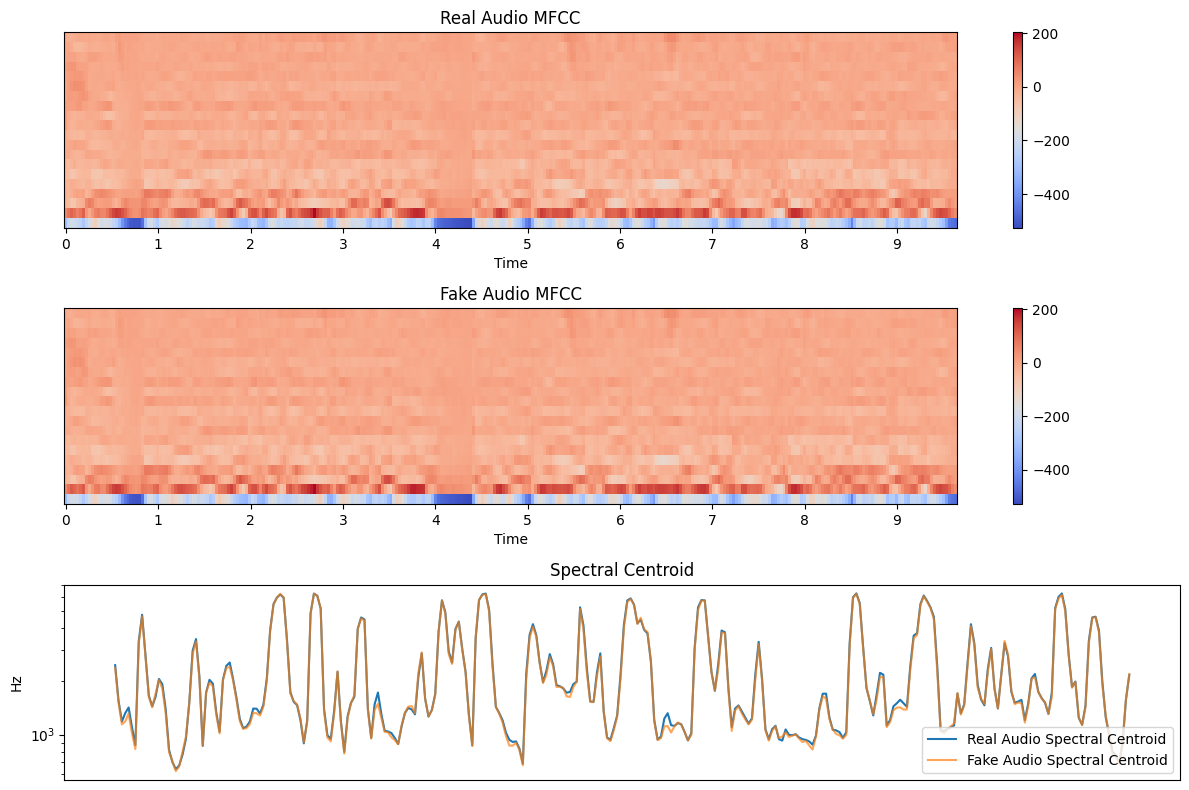

Spectral Centroid Real: Mean = 2254.35, Variance = 2299173.54
Spectral Centroid Fake: Mean = 2215.76, Variance = 2263516.10
Spectral Centroid: t-statistic = 0.3134, p-value = 0.7541


In [160]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display as ld
from scipy.stats import ttest_ind
import soundfile as sf

# Load audio files
real_audio, real_sr = sf.read('/app/data/temp/real.wav')
fake_audio, fake_sr = sf.read('/app/data/temp/fake.wav')

# Resample audio if needed
real_audio = librosa.resample(real_audio, orig_sr=real_sr, target_sr=16000)
fake_audio = librosa.resample(fake_audio, orig_sr=fake_sr, target_sr=16000)
real_sr = fake_sr = 16000

# Compute MFCCs
mfcc_real = librosa.feature.mfcc(y=real_audio, sr=real_sr, n_mfcc=20)
mfcc_fake = librosa.feature.mfcc(y=fake_audio, sr=fake_sr, n_mfcc=20)

# Compute Spectral Centroid
spectral_centroid_real = librosa.feature.spectral_centroid(y=real_audio, sr=real_sr)[0]
spectral_centroid_fake = librosa.feature.spectral_centroid(y=fake_audio, sr=fake_sr)[0]

# Compute Spectral Bandwidth
spectral_bandwidth_real = librosa.feature.spectral_bandwidth(y=real_audio, sr=real_sr)[0]
spectral_bandwidth_fake = librosa.feature.spectral_bandwidth(y=fake_audio, sr=fake_sr)[0]

# Plot Spectral Features
plt.figure(figsize=(12, 8))

# Plot MFCCs
plt.subplot(3, 1, 1)
librosa.display.specshow(mfcc_real, sr=real_sr, x_axis='time')
plt.colorbar()
plt.title('Real Audio MFCC')

plt.subplot(3, 1, 2)
librosa.display.specshow(mfcc_fake, sr=fake_sr, x_axis='time')
plt.colorbar()
plt.title('Fake Audio MFCC')

# Plot Spectral Centroid
plt.subplot(3, 1, 3)
plt.semilogy(spectral_centroid_real, label='Real Audio Spectral Centroid')
plt.semilogy(spectral_centroid_fake, label='Fake Audio Spectral Centroid', alpha=0.7)
plt.ylabel('Hz')
plt.xticks([])
plt.title('Spectral Centroid')
plt.legend()

plt.tight_layout()
plt.show()

# Statistical Analysis
def compute_statistics(feature):
    mean = np.mean(feature)
    variance = np.var(feature)
    return mean, variance

def perform_t_tests(feature_real, feature_fake):
    t_stat, p_value = ttest_ind(feature_real, feature_fake)
    return {'t_stat': t_stat, 'p_value': p_value}

# Compute statistics and perform t-tests
mean_real, var_real = compute_statistics(spectral_centroid_real)
mean_fake, var_fake = compute_statistics(spectral_centroid_fake)

t_test_results = perform_t_tests(spectral_centroid_real, spectral_centroid_fake)

print(f'Spectral Centroid Real: Mean = {mean_real:.2f}, Variance = {var_real:.2f}')
print(f'Spectral Centroid Fake: Mean = {mean_fake:.2f}, Variance = {var_fake:.2f}')
print(f'Spectral Centroid: t-statistic = {t_test_results["t_stat"]:.4f}, p-value = {t_test_results["p_value"]:.4f}')


In [116]:
from scipy.signal import butter, filtfilt

# Function to apply a bandpass filter
def bandpass_filter(audio_array, sampling_rate, lowcut, highcut):
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(1, [low, high], btype='band')
    y = filtfilt(b, a, audio_array)
    return y

In [131]:
import soundfile as sf

# Define the frequency range for the band-pass filter
lowcut = 6000  # Low cut-off frequency in Hz
highcut = 7000.0  # High cut-off frequency in Hz

# Apply the band-pass filter to the audio signal
real_filtered_audio = bandpass_filter(real_audio, real_sr, lowcut, highcut)

# Save the filtered audio to a file (optional)
sf.write('filtered_audio.wav', filtered_audio, real_sr)

# Play the filtered audio
Audio(real_filtered_audio, rate=real_sr)

In [132]:
import soundfile as sf

# Define the frequency range for the band-pass filter
lowcut = 6000  # Low cut-off frequency in Hz
highcut = 7000.0  # High cut-off frequency in Hz

# Apply the band-pass filter to the audio signal
fake_filtered_audio = bandpass_filter(fake_audio, fake_sr, lowcut, highcut)

# Save the filtered audio to a file (optional)
sf.write('filtered_audio.wav', filtered_audio, fake_sr)

# Play the filtered audio
Audio(fake_filtered_audio, rate=fake_sr)

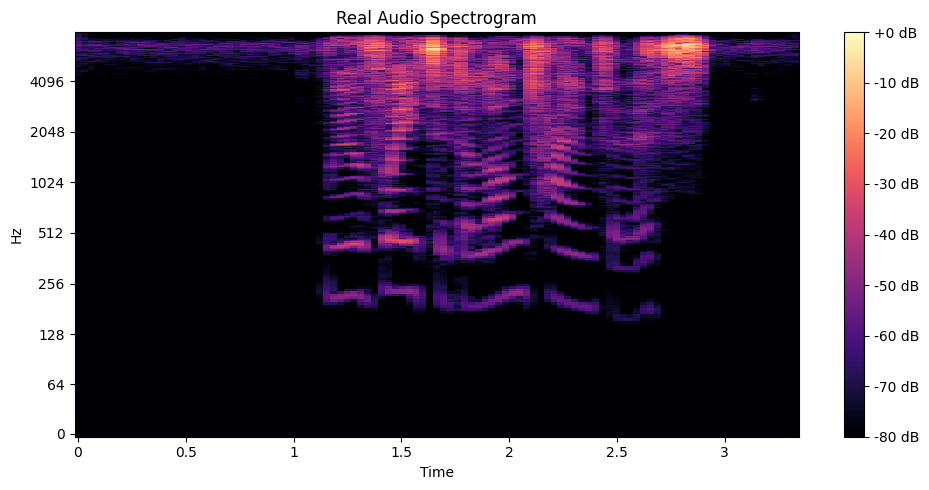

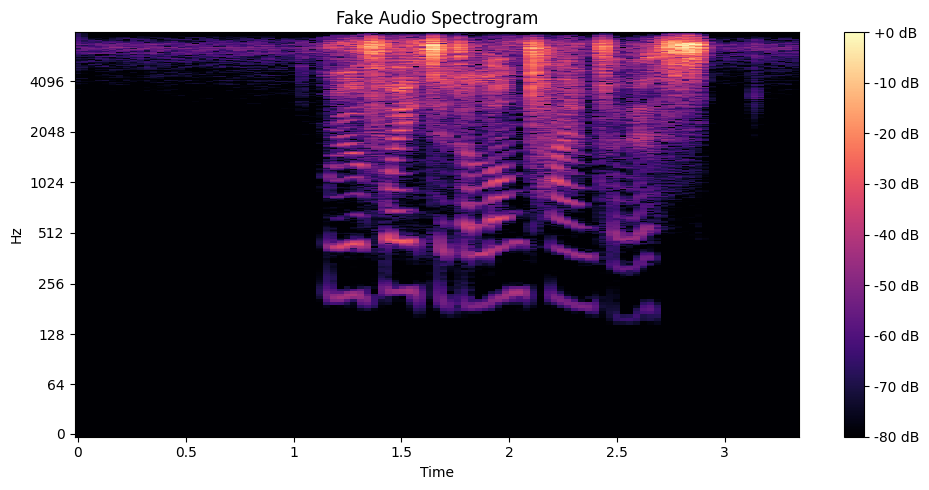

Real Audio Spectrogram: Mean = -65.39, Variance = 257.86
Fake Audio Spectrogram: Mean = -61.77, Variance = 306.09


In [134]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display as ld

def compute_spectrogram_stats(audio_array, sr):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_array)), ref=np.max)
    mean = np.mean(D)
    variance = np.var(D)
    return mean, variance

def plot_spectrogram(audio_array, sr, title='Spectrogram'):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_array)), ref=np.max)
    plt.figure(figsize=(10, 5))
    ld.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return D

# Load your filtered audio samples
# Assuming real_filtered_audio and fake_filtered_audio are your filtered audio arrays
# and real_sr and fake_sr are their corresponding sampling rates

# Plot spectrograms for real and fake audio
D_real = plot_spectrogram(real_filtered_audio, real_sr, title='Real Audio Spectrogram')
D_fake = plot_spectrogram(fake_filtered_audio, fake_sr, title='Fake Audio Spectrogram')

# Compute statistical properties
mean_real, var_real = compute_spectrogram_stats(real_filtered_audio, real_sr)
mean_fake, var_fake = compute_spectrogram_stats(fake_filtered_audio, fake_sr)

print(f'Real Audio Spectrogram: Mean = {mean_real:.2f}, Variance = {var_real:.2f}')
print(f'Fake Audio Spectrogram: Mean = {mean_fake:.2f}, Variance = {var_fake:.2f}')


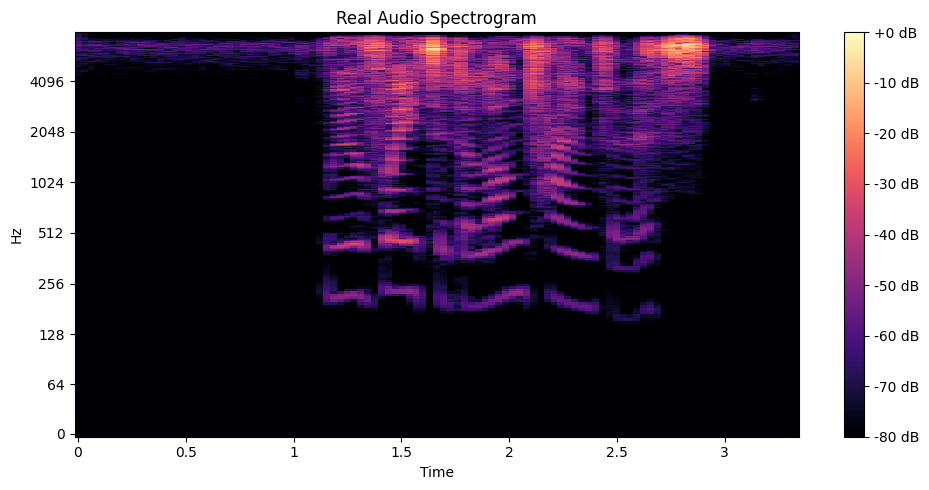

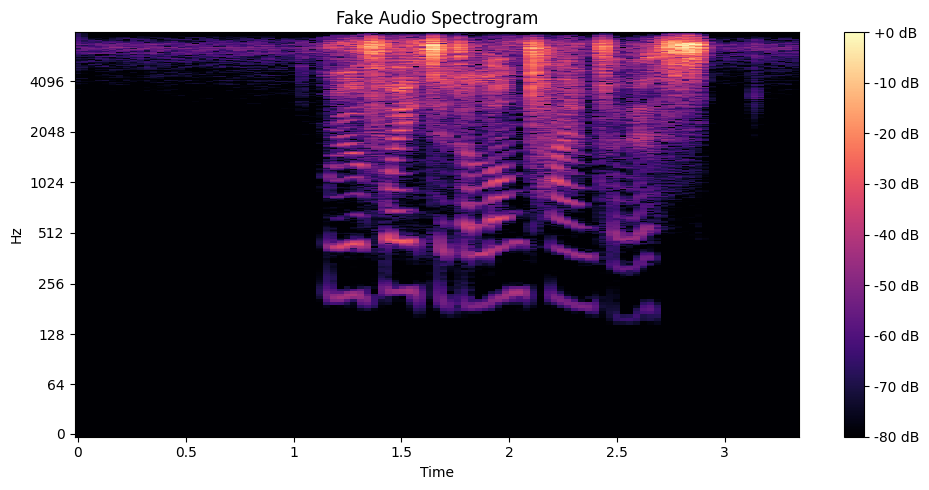

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display as ld

def plot_spectrogram(audio_array, sr, title='Spectrogram'):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_array)), ref=np.max)
    plt.figure(figsize=(10, 5))
    ld.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# # Load and process your audio samples
# audio_id = all_audio_ids[535]
# real_audio, real_sr = load_audio(audio_id, 'R')
# fake_audio, fake_sr = load_audio(audio_id, 'F02') 

# real_audio, real_sr = resample_audio(real_audio, real_sr, target_sr=16000)
# fake_audio, fake_sr = resample_audio(fake_audio, fake_sr, target_sr=16000)

# Plot spectrograms for real and fake audio
plot_spectrogram(real_filtered_audio, real_sr, title='Real Audio Spectrogram')
plot_spectrogram(fake_filtered_audio, fake_sr, title='Fake Audio Spectrogram')


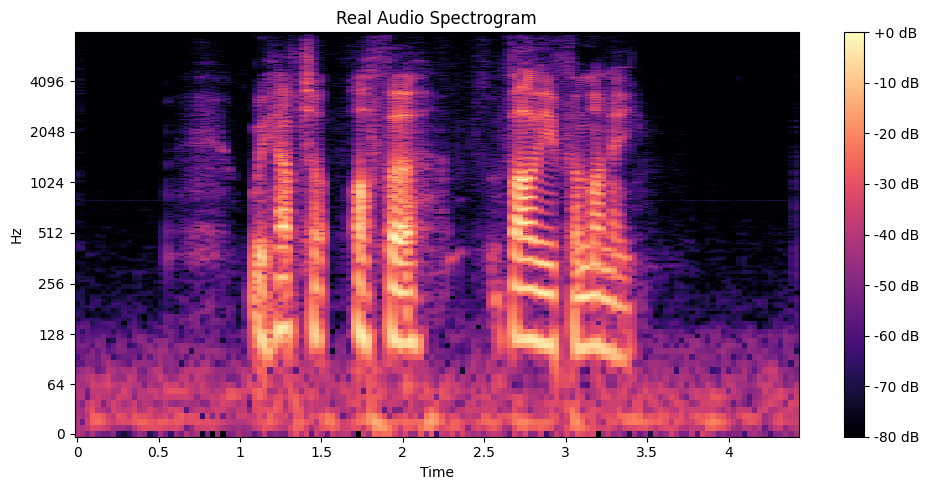

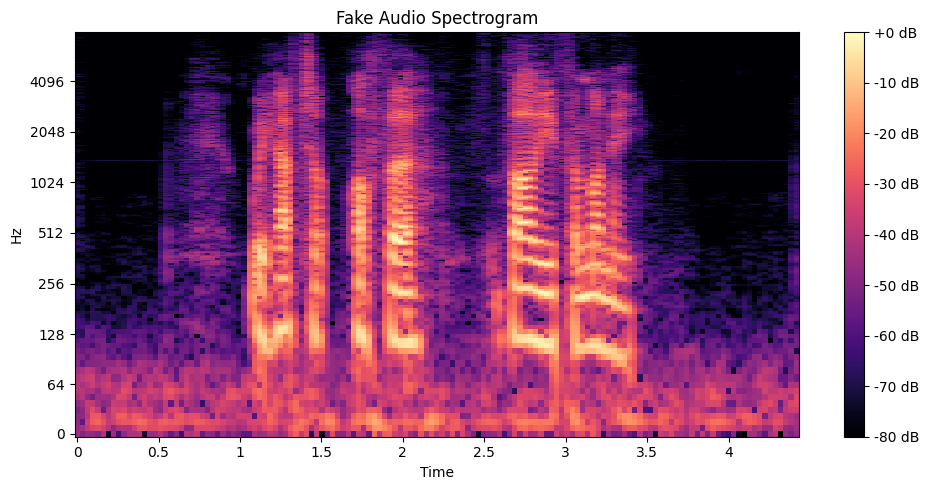

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display as ld

def plot_spectrogram(audio_array, sr, title='Spectrogram'):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_array)), ref=np.max)
    plt.figure(figsize=(10, 5))
    ld.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Load and process your audio samples
audio_id = all_audio_ids[535]
real_audio, real_sr = load_audio(audio_id, 'R')
fake_audio, fake_sr = load_audio(audio_id, 'F02') 
real_audio, real_sr = resample_audio(real_audio, real_sr, target_sr=16000)
fake_audio, fake_sr = resample_audio(fake_audio, fake_sr, target_sr=16000)

# Plot spectrograms for real and fake audio
plot_spectrogram(real_audio, real_sr, title='Real Audio Spectrogram')
plot_spectrogram(fake_audio, fake_sr, title='Fake Audio Spectrogram')


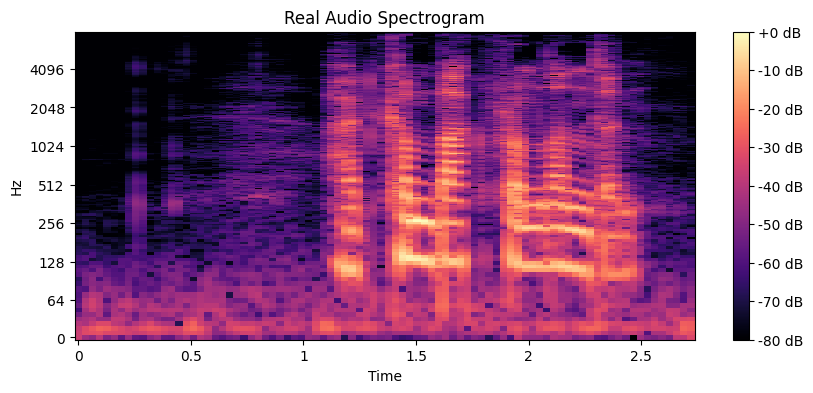

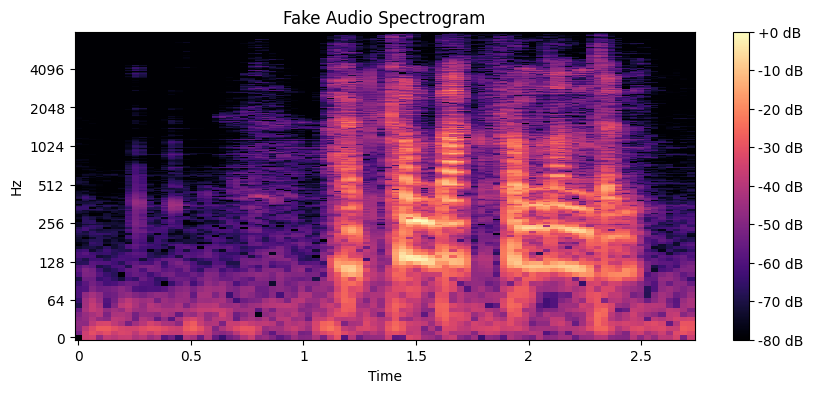

In [88]:

# Loading and visualizing spectrograms for a few samples
# audio_id = 'p225_002'
# real_audio, real_sr = load_audio(audio_id, 'R')
# fake_audio, fake_sr = load_audio(audio_id, 'F01') 


# Compute spectrograms
D_real = librosa.amplitude_to_db(np.abs(librosa.stft(real_audio)), ref=np.max)
D_fake = librosa.amplitude_to_db(np.abs(librosa.stft(fake_audio)), ref=np.max)

# Determine common vmin and vmax for consistent scaling
vmin = min(D_real.min(), D_fake.min())
vmax = max(D_real.max(), D_fake.max())

# Plot spectrograms with the same scale
plot_spectrogram(real_audio, real_sr, title='Real Audio Spectrogram', vmin=vmin, vmax=vmax)
plot_spectrogram(fake_audio, fake_sr, title='Fake Audio Spectrogram', vmin=vmin, vmax=vmax)

In [34]:
# Frequency Range Analysis
def compute_energy_distribution(audio_array, sr, n_fft=2048, hop_length=512):
    S = np.abs(librosa.stft(audio_array, n_fft=n_fft, hop_length=hop_length))
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    energy_distribution = np.sum(S, axis=1)
    return freqs, energy_distribution

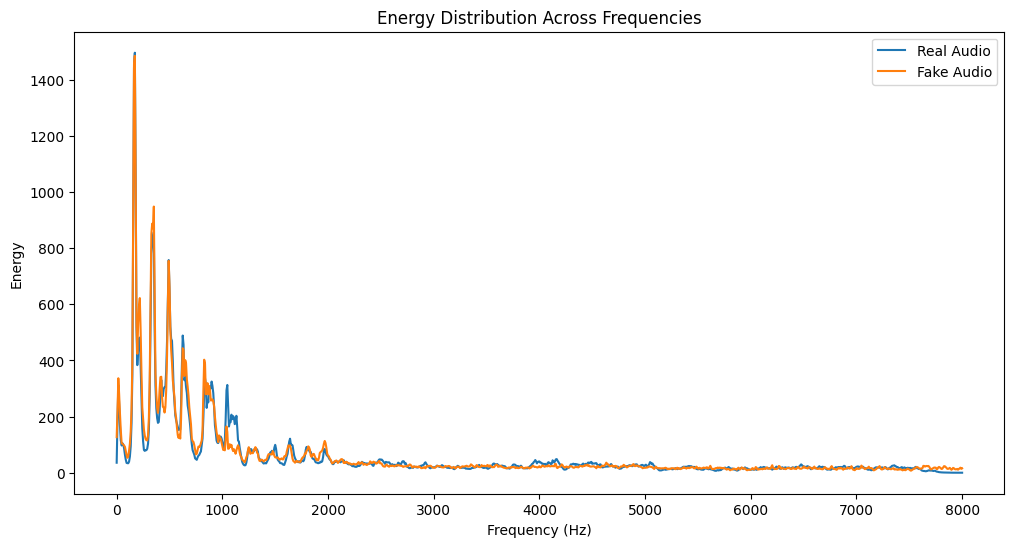

In [15]:
real_freqs, real_energy = compute_energy_distribution(real_audio, real_sr)
fake_freqs, fake_energy = compute_energy_distribution(fake_audio, fake_sr)

plt.figure(figsize=(12, 6))
plt.plot(real_freqs, real_energy, label='Real Audio')
plt.plot(fake_freqs, fake_energy, label='Fake Audio')
plt.title('Energy Distribution Across Frequencies')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Energy')
plt.legend()
plt.show()

### Resampling to ensure both audios have same sampling rate

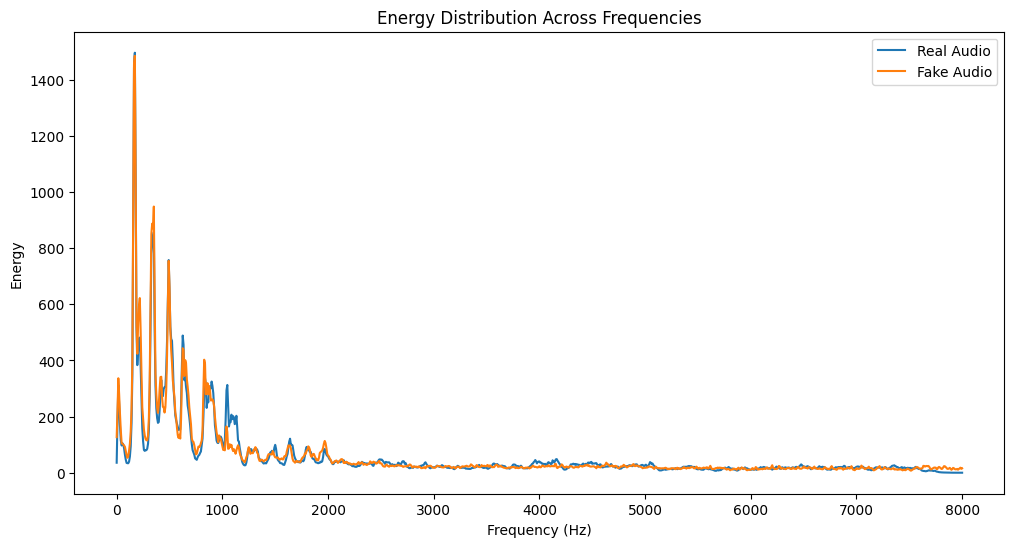

In [37]:
# Resampling audio
target_sr = 16000

real_audio_resampled, real_sr_resampled = resample_audio(real_audio, real_sr, target_sr=target_sr)
fake_audio_resampled, fake_sr_resampled = resample_audio(fake_audio, fake_sr, target_sr=target_sr) 

real_freqs, real_energy = compute_energy_distribution(real_audio_resampled, real_sr_resampled)
fake_freqs, fake_energy = compute_energy_distribution(fake_audio_resampled, fake_sr_resampled)

plt.figure(figsize=(12, 6))
plt.plot(real_freqs, real_energy, label='Real Audio')
plt.plot(fake_freqs, fake_energy, label='Fake Audio')
plt.title('Energy Distribution Across Frequencies')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Energy')
plt.legend()
plt.show()

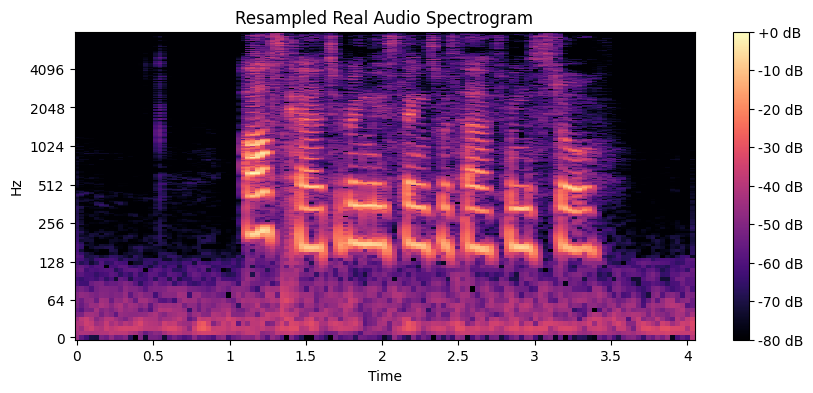

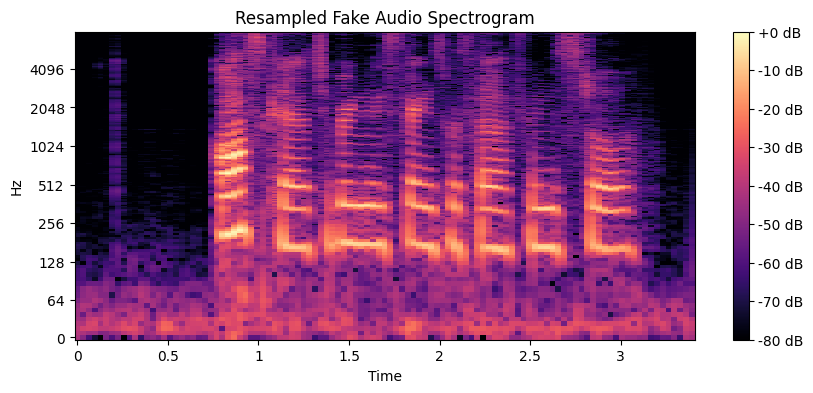

In [38]:
plot_spectrogram(real_audio_resampled, real_sr_resampled, title='Resampled Real Audio Spectrogram')
plot_spectrogram(fake_audio_resampled, fake_sr_resampled, title='Resampled Fake Audio Spectrogram')

### Analyze Multiple Versions

In [43]:
def get_audio_data(ids=None, indices=None, first_n=None, last_n=None, random_n=None, seed=None):
    audio_df = pd.DataFrame(columns=['audio_id', 'real_or_fake', 'audio_array', 'sampling_rate'])
    rows = []
    iterable_ds = get_iterable_dataset(ids=ids, indices=indices, first_n=first_n, last_n=last_n, random_n=random_n, seed=seed)
    for sample in iterable_ds:
        audio_array = sample['audio']['array']
        sampling_rate = sample['audio']['sampling_rate']
        real_or_fake = sample['real_or_fake']
        audio_id = sample['audio_id']
        
        rows.append({
            'audio_id': audio_id,
            'real_or_fake': real_or_fake,
            'audio_array': audio_array,
            'sampling_rate': sampling_rate
        })
    
    audio_df = pd.DataFrame(rows)
    
    return audio_df

audio_df = get_audio_data(first_n=1) 

In [48]:
# Function to analyze and plot energy distribution for multiple fake versions
def analyze_multiple_versions(audio_df, audio_id, fake_versions, target_sr=16000):
    real_audio, real_sr = load_audio(audio_id, 'R')
    real_audio_resampled, real_sr_resampled = resample_audio(real_audio, real_sr, target_sr=target_sr)
    
    real_freqs, real_energy = compute_energy_distribution(real_audio_resampled, real_sr_resampled)
    
    plt.figure(figsize=(12, 6))
    
    # Plot energy distribution of the real audio
    plt.plot(real_freqs, real_energy, label='Real Audio', linewidth=2)
    
    # Plot energy distributions of the fake audios
    for fake_version in fake_versions:
        fake_audio, fake_sr = load_audio(audio_id, fake_version)
        fake_audio_resampled, fake_sr_resampled = resample_audio(fake_audio, fake_sr, target_sr=target_sr)
        
        fake_freqs, fake_energy = compute_energy_distribution(fake_audio_resampled, fake_sr_resampled)
        
        plt.plot(fake_freqs, fake_energy, label=f'Fake Audio ({fake_version})', alpha=0.7)
    
    plt.title('Energy Distribution Across Frequencies')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Energy')
    plt.legend()
    plt.show()